In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
!git clone https://github.com/ahmetkrgztr/IAU_workshop.git

Cloning into 'IAU_workshop'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [ ]:
!unzip IAU_workshop/mri_images.zip -d ./mri_imgs
!unzip IAU_workshop/ct_images.zip 

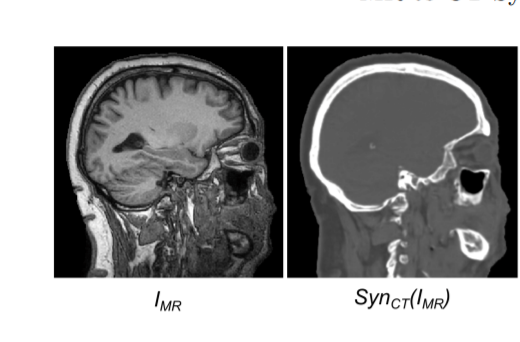

In [ ]:

from IPython.display import Image
Image(filename='./drive/MyDrive/notebook_images/mr_ct.png',width=600, height=500)

# MR görüntülerinden BT görüntüsü sentezleme

*  Zaman, para ve hastayı koruma amacıyla gereksiz BT çekimlerinin önüne geçmek
*  Halihazırda MR'ı çekilmiş hastaların görüntülerinde BT sentezlemek

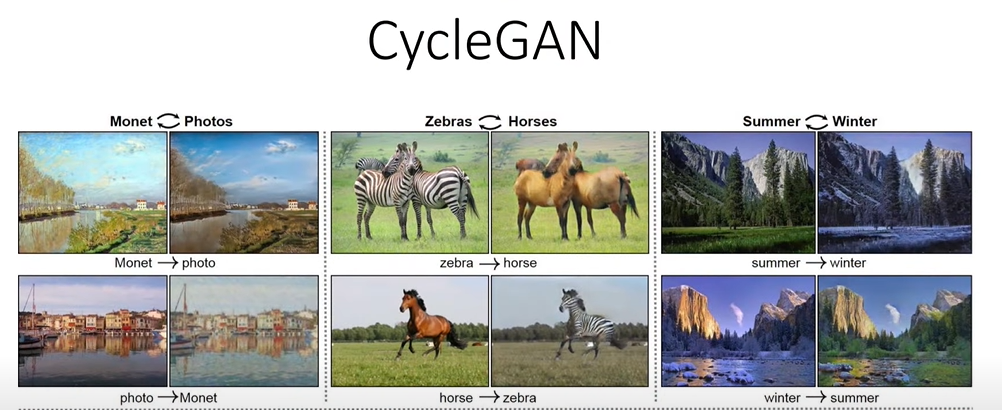

In [ ]:
Image(filename='./drive/MyDrive/notebook_images/gan_intro.png',width=1200, height=500)

# Basit GAN

*  Bir Üretici ve bir Ayırıcı
*  Üretici ve Ayırıcı ağın lossları

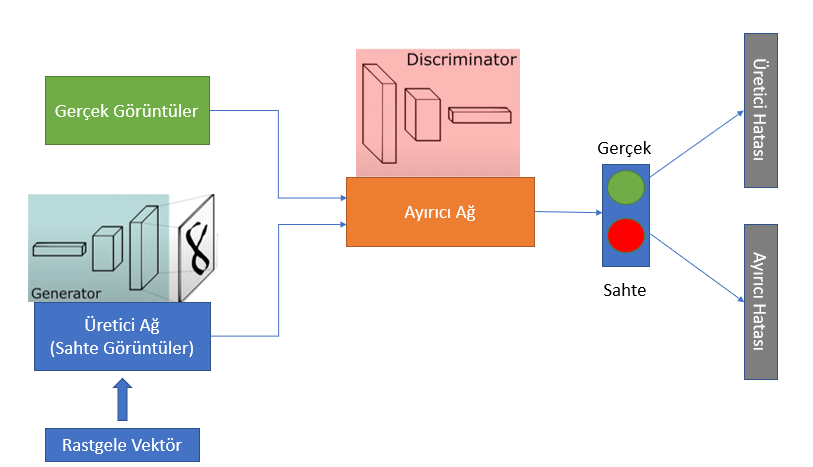

In [ ]:
Image(filename='./drive/MyDrive/notebook_images/basic_GAN.png',width=800, height=400)

# CycleGAN 

*  Döngü halinde 2 tane Üretici ve Ayırıcı
*  Adverserial loss
*  Consistencey loss
*  Identity loss

Jun-Yan Zhu et. al., Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks, 2020

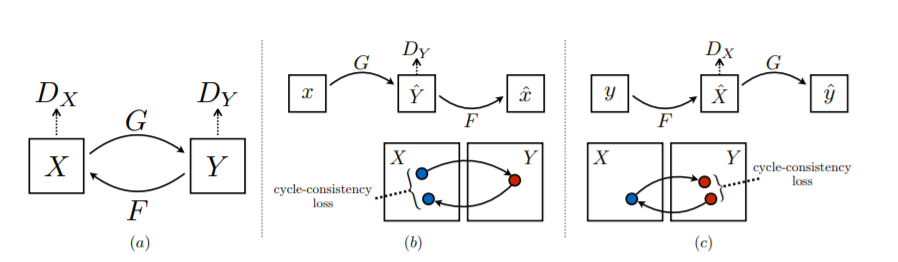

In [ ]:
Image(filename='./drive/MyDrive/notebook_images/gan_3.png',width=1000, height=500)

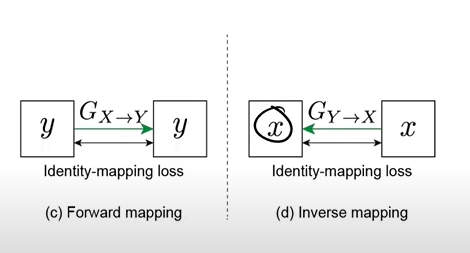

In [ ]:
Image(filename='./drive/MyDrive/notebook_images/gan_4.png',width=800, height=500)

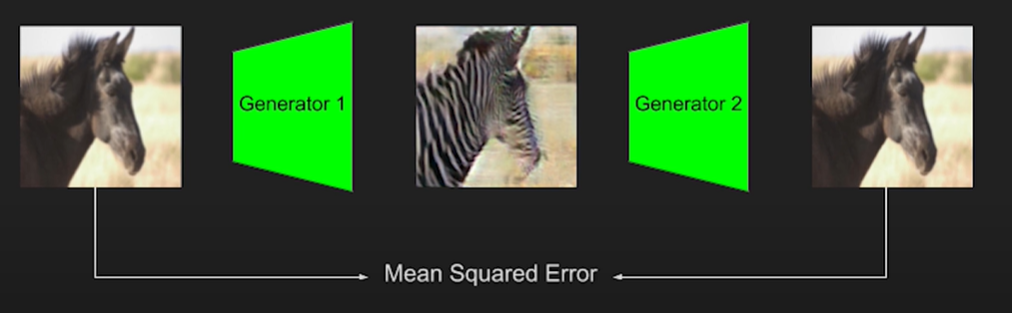

In [ ]:
Image(filename='./drive/MyDrive/notebook_images/gan_5.png',width=1000, height=500)

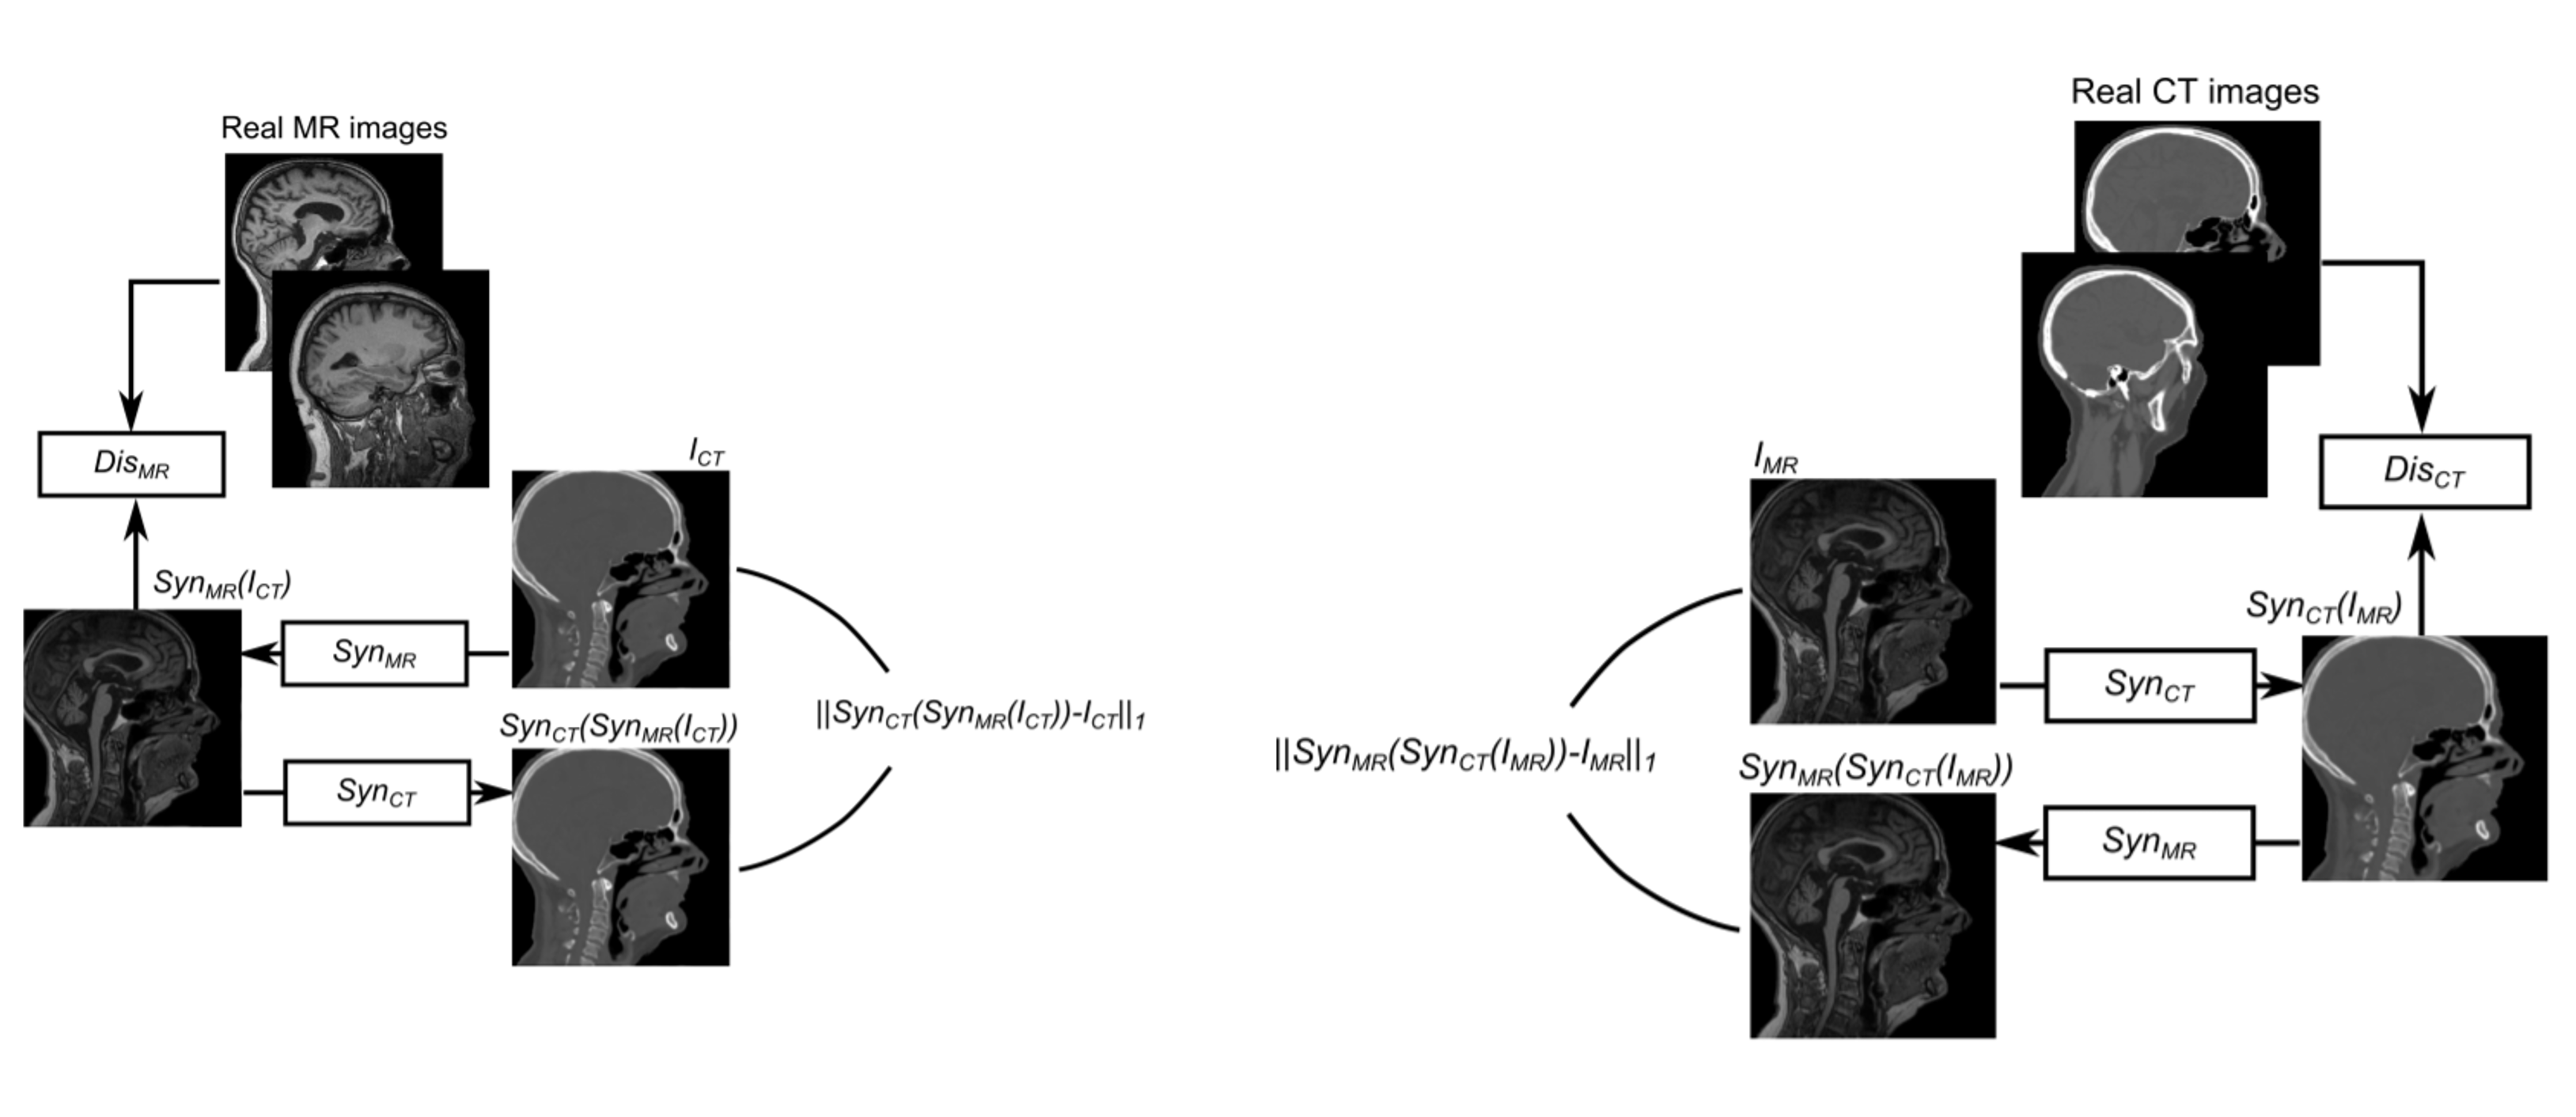

In [ ]:
Image(filename='./drive/MyDrive/notebook_images/back_and _forw.png',width=1200, height=500)

# Elimizdeki veriler:
  ##  Head CT ~20k
  ##  Head MR ~15k

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12737885175833183370
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4505547853775301019
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [4]:
!pip install -q git+https://github.com/tensorflow/examples.git

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from PIL import Image
from albumentations import Resize
import numpy as np
from tqdm import tqdm

AUTOTUNE = tf.data.AUTOTUNE

In [6]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256


In [7]:
ct_data_dir = "ct_images/"

ct_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  ct_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(256, 256),
  batch_size=1)

ct_valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  ct_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(256, 256),
  batch_size=1)

Found 160 files belonging to 1 classes.
Using 128 files for training.
Found 160 files belonging to 1 classes.
Using 32 files for validation.


In [8]:
mri_data_dir = "mri_imgs"

mri_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  mri_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(256, 256),
  batch_size=1)

mri_valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  mri_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(256, 256),
  batch_size=1)

Found 126 files belonging to 1 classes.
Using 101 files for training.
Found 126 files belonging to 1 classes.
Using 25 files for validation.


In [10]:
def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

def preprocess_image_train(image, label):
#image = random_jitter(image)
    image = normalize(image)
    return image

def preprocess_image_test(image, label):
    image = normalize(image)
    return image


In [11]:
ct_train_ds = ct_train_ds.map(
    preprocess_image_train, num_parallel_calls=8).cache().shuffle(
    BUFFER_SIZE)
mri_train_ds = mri_train_ds.map(
    preprocess_image_train, num_parallel_calls=8).cache().shuffle(
    BUFFER_SIZE)

ct_valid_ds = ct_valid_ds.map(
    preprocess_image_test, num_parallel_calls=8).cache().shuffle(
    BUFFER_SIZE)

mri_valid_ds = mri_valid_ds.map(
    preprocess_image_test, num_parallel_calls=8).cache().shuffle(
    BUFFER_SIZE)


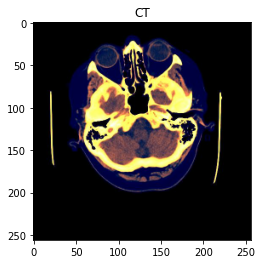

In [13]:
sample_ct = next(iter(ct_train_ds))

plt.title('CT')
plt.imshow(sample_ct[0] * 0.5 + 0.5)


In [ ]:
sample_ct

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        [[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        [[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        ...,

        [[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        [[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        [[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -

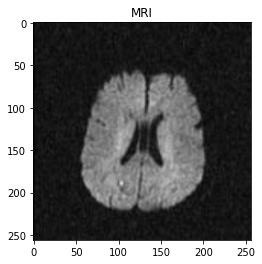

In [14]:
sample_mri = next(iter(mri_train_ds))

plt.title('MRI')
plt.imshow(sample_mri[0] * 0.5 + 0.5)


In [15]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)


In [16]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [ ]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5


In [ ]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)


In [ ]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1


In [ ]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss


In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [ ]:
checkpoint_path = "checkpoints/"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)


In [ ]:
EPOCHS = 10

def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()


In [ ]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))


Epoch: 9  Step: 100

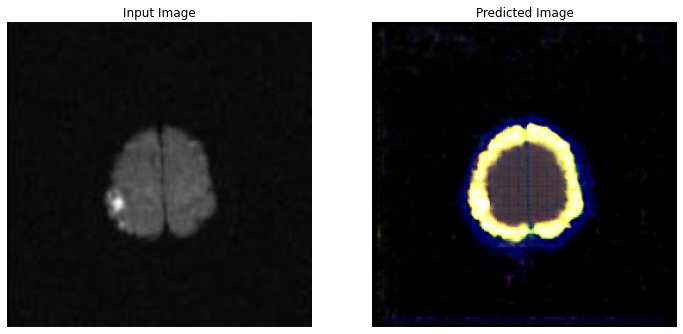

Time taken for epoch 10 is 44.51239204406738 sec



In [ ]:
LAMBDA = 10
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((mri_train_ds,ct_train_ds)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            clear_output(wait=True)
            print ('Epoch:',epoch, " Step:", n , end='')
            generate_images(generator_g, image_x)
        elif n % 1000 == 0:
          ckpt_save_path = ckpt_manager.save()
          print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
        n += 1


    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))
